## Data Generator 
Created: February 14, 2020

This series of notebooks generate synthetic data for different components of the food supply chain. It models activities like restaurant orders using normal distributions with parameters number of events $n$, mean $\mu$, and standard deviation $\sigma$.  After the distribution or distributions are is created, a function samples the distribution and generates $n$ events for a specific type of event: telemetry event, event enrichment, or session enrichment event. The events are written to a text file and exported locally. 

This notebook specifically allows a user to submit $k$ sets of parameters (orders, mean, and standard deviation) through a text file. The data generator creates these distributions and samples from them to create events following the current data model. Results of the sampling are shown as a histogram with the distribution overlayed on top. 

The outputs of the events follows the data model described in this document: https://zumepizza.atlassian.net/wiki/spaces/TERA/pages/615318459/Data+Model

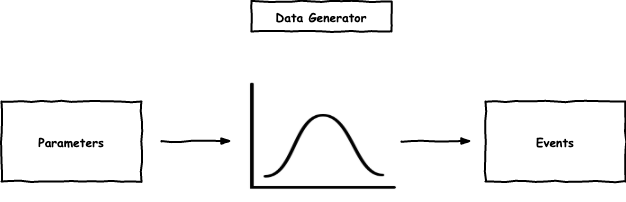

In [41]:
from IPython.display import Image
Image(filename="/Users/newtonkwan/Documents/zume/data_generator/data_generator_pipeline.png")

### Version 1 (2/6/20)
- Shows how to create a normal distribution
- Outputs three text files, each with one of example of the following: telemetry event, enriched event, and enriched session. 

### Version 2 (2/10/20)
- Same as version 1 including the following
- Write three functions that allow a user to specify the number of events to simulate for each of the three kinds of events. The outputs are three text files, each with n number of events of the following kind: telemetry event, enriched event, and enriched session. 

### Version 3 (2/10/20)
- Same as version 2 including the following
- Written a function that generates synthetic data for tomato harvests by month that follows a normal distribution whose parameters can be user specified. 
- The event enrichment events generator can generate 100,000 events every 5 seconds and write those events in about 5 seconds for a total of 10 seconds per 100,000 events. 

### Version 4 (2/12/20)
- Same as version 3 including the following
- Written a function that generates synthetic data for Tito's Tacos that has two normal distributions to describe lunch and dinner orders using 6 user specfied parameters (number of lunch orders, number of dinner orders, lunch mean, dinner mean, lunch standard deviation, and dinner standard deviation) to generate data. 
- Added details Part C to telemetry events for orders because I did not consider order details to be event enrichment.
- Plotted a denormlaized normal distribution (amplitude * pdf) rather than normalizing the histogram and fitting it to a pdf because it is more intuitive to view orders of the y-axis than a probability density for number of orders 

### Version 5 (2/12/20)
- Same as version 4 including the following
- Wrote a function that can take in an arbitrary number of sets of parameters (say lunch and dinner or breakfast, lunch, dinner, and dessert).
- Instead of hardcoding in the parameters, a user can specify the parameters in a textfile 
- The readability of the code has been greatly improved by abstracting out the event generating part into its own function, which allows for n number of sets of parameters. 

### Version 6 (2/13/20)
- Same as version 5 including the following
- Explicitly wrote assumptions for the data being generated, including each event being a unique consumer, each event being a unique session, and each event being only one business customer. 
- Added a simple diagram explaining the data generator. 

In [6]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats
import json
from datetime import datetime,timezone
from dateutil import tz
import uuid
import random
import time

In [7]:
def write_to_file(events, filename):
    '''
    Converts a list of dictionaries into a list of json events, which are 
    then saved as a text file named filename
    Input: events --> a list of dictionaries, each of which is an event. 
           filename --> string name of the file
    Output: Print confirmation of the number of events written and filename 
    '''
    n = len(events)
    with open(filename, 'w') as file_json: 
        json.dump(events, file_json)
    
    print("Successfully created the file", filename, "with", n, "events")
    return 

In [8]:
def sample_distributions(num_of_orders, mu, sigma):
    '''
    This function takes three parameters, creates a distribution, and samples that 
    distribution to create a list of events. 
    
    Ex: [100, 6, 1]
    The function would create a normal distribution with n = 100, mean = 6, and 
    standard deviation = 1, sample the distribution 100 times, creating 100 events 
    in the format of the data model. It will return a list of dictionaries, where a 
    single dictionary is a single event. 
    
    Input: num_of_orders --> integer: number of orders
           mu --> float: mean of the distribution
           sigma --> float: standard deviation of the distribution 
    Output: returns a list of dictionaries of length num_of_orders
    '''
    
    events = [] 
    samples = []
    
    # assumptions
    # customer is the same for all events 
    customer = "Titos Tacos"       
    
    # the hub is always the same 
    hub_id = str(uuid.uuid1())   
    
    # the session is always unique per event  
    
    for i in range(num_of_orders):
        event_dict = {} 
        
        # setting up datetime variables
        from_zone = tz.tzutc()
        to_zone = tz.tzlocal()
        utc = datetime.utcnow() 
        utc = utc.replace(tzinfo=from_zone)
        local = utc.astimezone(to_zone)
        
        # part A telemetry event
        correlation_id = str(uuid.uuid1())   # always unique for each event 
        customer = "Titos Tacos"             # business customer the row was generated for
        type_of_data = "event"               # default type of data 
        version = "1.0.0"                    # default is 1.0.0 until change needed
        source = "telemetry"                 # supports telemetry for now, no enrichment 
        UTCtimestamp = str(utc)              # convert utc datetime into a string

        # part B telemetry details
        event_type = "customer_order"        # customer in this sense means the consumer
        customer_id = str(uuid.uuid1())      # ID of a specific customer (meaning consumer)
        session_id = str(uuid.uuid1())       # unique ID of the session, currently always unique
        hub_id = hub_id                      # unique to the restaurant location
        hub_location = None                  # None if it's stationary
        menu_version =  "1.0.0"              # hardcoded to 1.0.0 for now 
        experiments = None                   # part of the data model
        localtime = str(local)               # local time as a string 
        UTCeventtime = str(utc)              # utc time as a string 

        # part C telemetry details 
        order_snapshot = []
        hour_sample = round(np.random.normal(mu, sigma, 1)[0], 2)
        number_of_skus = random.randint(1,2) # generate 1 or 2 
        if number_of_skus == 1: 
            total = 6.0 
        else: 
            total = 15.50 
        for sku_num in range(number_of_skus):
            if sku_num == 0: 
                subtotal_sample = 6.0 
            else: 
                subtotal_sample = 9.50
            d = {"sku": sku_num+1, 
                 "amount": 1,
                 "subtotal": subtotal_sample,
                 "total": total,
                 "hour of the day": hour_sample
                 }
            order_snapshot.append(d)
            
        samples.append(hour_sample)
    
        
        # part C telemetry details
        partC_event_details_dict = {"order_snapshot": order_snapshot
                                   }
        
        # part B telemetry details
        partB_event_details_dict = {"event_type": event_type,           # Every event (part A type) has a event type in part B
                                    "customer_id": customer_id,         # The ID for a specific customer. This is null if a customer is not logged in or we cannot find it 
                                    "session_id": session_id,           # An ID that joins a set of events into a specific customer session. 
                                    "hub_id": hub_id,                   # The ID for the specific Hub (kiosk, etc.) that is being viewed
                                    "hub_location": hub_location,       # The location of the specific hub. For hub's in which the location does not every change, such as a fixed Kiosk, this field will be null as location can be obtained through a lookup
                                    "menu_version": menu_version,       # You can lookup details about this menu with this id.  
                                    "experiments": experiments,         # If a user is in an experiment, it would be represented here in the format experiment:treatment with pipe delimitation.  E.G. if the user was in treatment 2 of a ux experiment titled redbuttons, and treatment 12 of an experiment titled aggressivemarketing, the field would be "redbuttons:2|aggressivemarketing:12
                                    "localtime": localtime,             # The local time this event was generated
                                    "UTCtime": UTCeventtime,            # The utc time this event was generated
                                    "details": partC_event_details_dict
                                   }
        
        # part A 
        event_dict = {"correlation_id": correlation_id,    # The is the id associated with all telemetry events 
                      "customer": customer,
                      "type": type_of_data,                # The type of data. Typically "event", which is something generated off of a specific event
                      "version": version,                  # The version of this data
                      "source": source,                    # Where the data was generated. Often "telemetry", but can be "enrichment".
                      "UTCtimestamp": UTCtimestamp,        # A timestamp for when this specific row of data was created 
                      "details": partB_event_details_dict  # Details is where part B data and part C data is stored.   
                      }
        
        events.append(event_dict)
    return events, samples

In [9]:
def generate_orders_by_hour(parameters):
    '''
    This function generates events based on distributions parametrized by parameters 
    Input: parameters --> list of lists of string parameters in the format [orders, mu, sigma]
    Output: order_events --> list of order_events
            order_samples --> list of lists of order samples
    '''
    
    order_events = [] 
    order_samples = [] 

    for p in parameters: 
        num_orders = p[0] 
        mu = p[1]
        sigma = p[2]
        events, samples = sample_distributions(num_orders, mu, sigma)
        order_events += events
        order_samples.append(samples) 
        
    return order_events, order_samples

Time to generate 650 events: 0.062 seconds


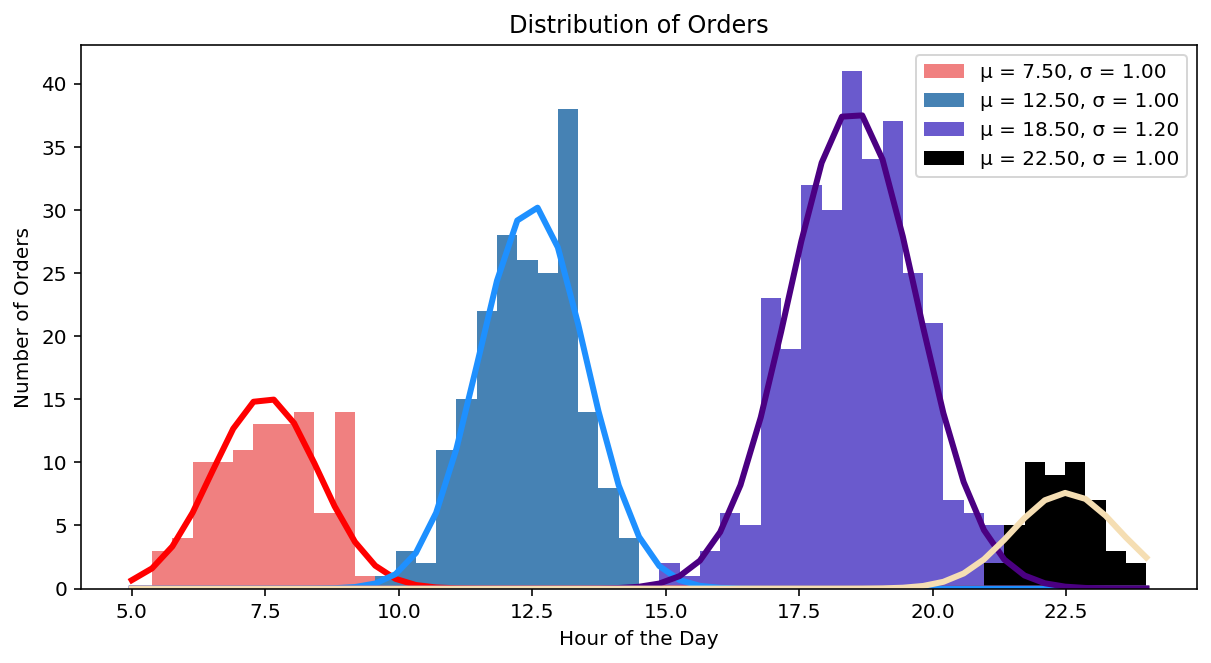

Successfully created the file v6_demo_titos_tacos_order_events.txt with 650 events
Time to write to file: 0.036 seconds
[
    {
        "correlation_id": "b68c9a2c-4f60-11ea-8e31-acde48001122",
        "customer": "Titos Tacos",
        "type": "event",
        "version": "1.0.0",
        "source": "telemetry",
        "UTCtimestamp": "2020-02-14 19:32:18.634325+00:00",
        "details": {
            "event_type": "customer_order",
            "customer_id": "b68c9ae0-4f60-11ea-8e31-acde48001122",
            "session_id": "b68c9b26-4f60-11ea-8e31-acde48001122",
            "hub_id": "b68c95cc-4f60-11ea-8e31-acde48001122",
            "hub_location": null,
            "menu_version": "1.0.0",
            "experiments": null,
            "localtime": "2020-02-14 11:32:18.634325-08:00",
            "UTCtime": "2020-02-14 19:32:18.634325+00:00",
            "details": {
                "order_snapshot": [
                    {
                        "sku": 1,
                        "a

In [16]:
path_to_params = "/Users/newtonkwan/Documents/zume/data_generator/parameters.txt"
with open(path_to_params) as f: 
    raw = f.read().splitlines()[2:]

parameters = []
for p in raw: 
    nth_params = list(map(float, p.split(",")))
    nth_params[0] = int(nth_params[0])
    parameters.append(nth_params)
    
interval = (5, 24) # 6am to 11pm 
num_of_bins = 50
dx = (interval[1] - interval[0]) / num_of_bins # interval length / number of bins = bin_width


generate_time_start = time.time()
events, order_samples = generate_orders_by_hour(parameters)
generate_time_taken = time.time() - generate_time_start 

print("Time to generate", len(events), "events:", round(generate_time_taken, 3), "seconds")

write_data_start = time.time()
filepath = "/Users/newtonkwan/Documents/zume/data_generator/" # change this for your own use
filename = "v6_demo_titos_tacos_order_events.txt"             # change this for your own use 
write_to_file(events, filename)
with open(filepath + filename) as file:
    data = json.load(file)

write_data_end = time.time()
write_time_taken = write_data_end - write_data_start 
print("Time to write to file:", round(write_time_taken, 3), "seconds")

print(json.dumps(data, indent=4, sort_keys=False)) # printing a nice format 